(cubic-slab-hwf-nb)=
# Hybrid Wannier functions in slab

Construct and compute Berry phases of hybrid Wannier functions.

In [1]:
from pythtb import TBModel, WFArray, Mesh
import matplotlib.pyplot as plt
import numpy as np

Set up model on bcc motif (CsCl structure), nearest-neighbor hopping only, but of two different strengths. Symmetry is orthorhombic with a simple $M_y$ mirror and two diagonal mirror planes containing the $y$ axis.

In [2]:
def set_model(delta, ta, tb):
    lat = [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]]
    orb = [[0.0, 0.0, 0.0], [0.5, 0.5, 0.5]]
    model = TBModel(3, 3, lat, orb)
    model.set_onsite([-delta, delta])
    for lvec in ([-1, 0, 0], [0, 0, -1], [-1, -1, 0], [0, -1, -1]):
        model.set_hop(ta, 0, 1, lvec)
    for lvec in ([0, 0, 0], [0, -1, 0], [-1, -1, -1], [-1, 0, -1]):
        model.set_hop(tb, 0, 1, lvec)

    return model

In [3]:
delta = 1.0  # site energy shift
ta = 0.4  # six weaker hoppings
tb = 0.7  # two stronger hoppings
bulk_model = set_model(delta, ta, tb)

print(bulk_model)

----------------------------------------
       Tight-binding model report       
----------------------------------------
r-space dimension           = 3
k-space dimension           = 3
number of spin components   = 1
periodic directions         = [0, 1, 2]
number of orbitals          = 2
number of electronic states = 2

Lattice vectors (Cartesian):
  # 0 ===> [ 1.000 ,    0   ,    0   ]
  # 1 ===> [   0   ,  1.000 ,    0   ]
  # 2 ===> [   0   ,    0   ,  1.000 ]
Orbital vectors (dimensionless):
  # 0 ===> [   0   ,    0   ,    0   ]
  # 1 ===> [ 0.500 ,  0.500 ,  0.500 ]
Site energies:
  # 0 ===> -1.000 
  # 1 ===>  1.000 
Hoppings:
  < 0 | H | 1 + [-1.0 ,  0.0 ,  0.0 ] >  ===> 0.4000 
  < 0 | H | 1 + [ 0.0 ,  0.0 , -1.0 ] >  ===> 0.4000 
  < 0 | H | 1 + [-1.0 , -1.0 ,  0.0 ] >  ===> 0.4000 
  < 0 | H | 1 + [ 0.0 , -1.0 , -1.0 ] >  ===> 0.4000 
  < 0 | H | 1 + [ 0.0 ,  0.0 ,  0.0 ] >  ===> 0.7000 
  < 0 | H | 1 + [ 0.0 , -1.0 ,  0.0 ] >  ===> 0.7000 
  < 0 | H | 1 + [-1.0 , -1.0 , -

Now make a slab model

In [4]:
# make slab model
num_layers = 9  # number of layers
slab_model = bulk_model.cut_piece(num_layers, 2, glue_edgs=False)

# remove top orbital so top and bottom have the same termination
slab_model = slab_model.remove_orb(2 * num_layers - 1)
slab_model.report(short=True)

----------------------------------------
       Tight-binding model report       
----------------------------------------
r-space dimension           = 3
k-space dimension           = 2
number of spin components   = 1
periodic directions         = [0, 1]
number of orbitals          = 17
number of electronic states = 17



In [5]:
# solve on grid to check insulating
nk = 10
k_1d = np.linspace(0, 1, nk, endpoint=False)
kpts = []
for kx in k_1d:
    for ky in k_1d:
        kpts.append([kx, ky])

evals = slab_model.solve_ham(kpts)

# delta > 0, so there are num_layers valence and num_layers - 1 conduction bands
en_valence = evals[:, :num_layers]
en_conduction = evals[:, num_layers + 1 :]

print(f"VB min, max = {np.min(en_valence):6.3f} , {np.max(en_valence):6.3f}")
print(f"CB min, max = {np.min(en_conduction):6.3f} , {np.max(en_conduction):6.3f}")

VB min, max = -4.447 , -1.000
CB min, max =  1.000 ,  4.447


In [6]:
nk = 9
mesh = Mesh(dim_k=2, axis_types=['k', 'k'])
mesh.build_grid(shape=(nk, nk))
print(mesh)

Mesh Summary
Type: grid
Dimensionality: 2 k-dim(s) + 0 λ-dim(s)
Number of mesh points: 81
Full shape: (9, 9, 2)
k-shape: (9, 9)
λ-shape: ()
k-axes: [0, 1]
λ-axes: []
Axis names: [k_0, k_1]
Endpoints included on axis: [◦, ◦]   (• yes, ◦ no/unknown)
Is a torus in k-space (all k-axes wrap): yes
Periodic axes: (axis 0, comp 0), (axis 1, comp 1)
Closed axes: None


In [7]:
bloch_arr = WFArray(slab_model, mesh)
bloch_arr.solve_mesh()

In [8]:
# initalize wf_array to hold HWFs, and Numpy array for HWFCs
hwf_arr = bloch_arr.empty_like(nstates=num_layers)
hwfc = np.zeros([nk, nk, num_layers])

# loop over k points and fill arrays with HW centers and vectors
for ix in range(nk):
    for iy in range(nk):
        (val, vec) = bloch_arr.position_hwf(
            [ix, iy], occ=list(range(num_layers)), dir=2, hwf_evec=True, basis="orbital"
        )
        hwfc[ix, iy] = val
        hwf_arr[ix, iy] = vec

# impose periodic boundary conditions
hwf_arr.impose_pbc(0, 0)
hwf_arr.impose_pbc(1, 1)

# compute and print mean and standard deviation of Wannier centers by layer
print("\nLocations of hybrid Wannier centers along z:\n")
print("  Layer      " + num_layers * "  %2d    " % tuple(range(num_layers)))
print("  Mean   " + num_layers * "%8.4f" % tuple(np.mean(hwfc, axis=(0, 1))))
print("  Std Dev" + num_layers * "%8.4f" % tuple(np.std(hwfc, axis=(0, 1))))


Locations of hybrid Wannier centers along z:

  Layer         0       1       2       3       4       5       6       7       8    
  Mean     0.0582  1.0097  2.0024  3.0006  4.0000  4.9994  5.9976  6.9903  7.9418
  Std Dev  0.0410  0.0114  0.0035  0.0010  0.0000  0.0010  0.0035  0.0114  0.0410


In [10]:
# compute and print layer contributions to polarization along x, then y
px = np.zeros((num_layers, nk))
py = np.zeros((num_layers, nk))
for n in range(num_layers):
    px[n, :] = hwf_arr.berry_phase(mu=0, state_idx=[n]) / (2*np.pi)
    py[n, :] = hwf_arr.berry_phase(mu=1, state_idx=[n]) / (2*np.pi)

print("\nBerry phases along x (rows correspond to k_y points):\n")
print("  Layer      " + num_layers * "  %2d    " % tuple(range(num_layers)))
for k in range(nk):
    print("         " + num_layers * "%8.4f" % tuple(px[:, k]))
# when averaging, don't count last k-point
px_mean = np.mean(px[:, :-1], axis=1)
py_mean = np.mean(py[:, :-1], axis=1)
print("\n  Ave    " + num_layers * "%8.4f" % tuple(px_mean))


Berry phases along x (rows correspond to k_y points):

  Layer         0       1       2       3       4       5       6       7       8    
           0.0604  0.0089  0.0021  0.0005  0.0000 -0.0005 -0.0021 -0.0089 -0.0604
           0.0565  0.0077  0.0017  0.0004 -0.0000 -0.0004 -0.0017 -0.0077 -0.0565
           0.0446  0.0047  0.0009  0.0002  0.0000 -0.0002 -0.0009 -0.0047 -0.0446
           0.0253  0.0014  0.0001  0.0000  0.0000 -0.0000 -0.0001 -0.0014 -0.0253
           0.0044  0.0000  0.0000  0.0000  0.0000 -0.0000 -0.0000 -0.0000 -0.0044
           0.0044  0.0000  0.0000  0.0000  0.0000 -0.0000 -0.0000 -0.0000 -0.0044
           0.0253  0.0014  0.0001  0.0000  0.0000 -0.0000 -0.0001 -0.0014 -0.0253
           0.0446  0.0047  0.0009  0.0002  0.0000 -0.0002 -0.0009 -0.0047 -0.0446
           0.0604  0.0089  0.0021  0.0005  0.0000 -0.0005 -0.0021 -0.0089 -0.0604

  Ave      0.0332  0.0036  0.0007  0.0002  0.0000 -0.0002 -0.0007 -0.0036 -0.0332


Similar calculations along $y$ give zero due to $M_y$ mirror symmetry.

In [11]:
nlh = num_layers // 2
sum_top = np.sum(py_mean[:nlh])
sum_bot = np.sum(py_mean[-nlh:])
print("\n  Surface sums: Top, Bottom = %8.4f , %8.4f\n" % (sum_top, sum_bot))


  Surface sums: Top, Bottom =  -0.0000 ,  -0.0000



These quantities are essentially the "surface polarizations" of the model as defined within the hybrid Wannier gauge.

:::{seealso}
_S. Ren, I. Souza, and D. Vanderbilt, "Quadrupole moments, edge polarizations, and corner charges in the Wannier representation,"
Phys. Rev. B 103, 035147 (2021)_.
:::

Text(0, 0.5, 'Contribution to $P_x$')

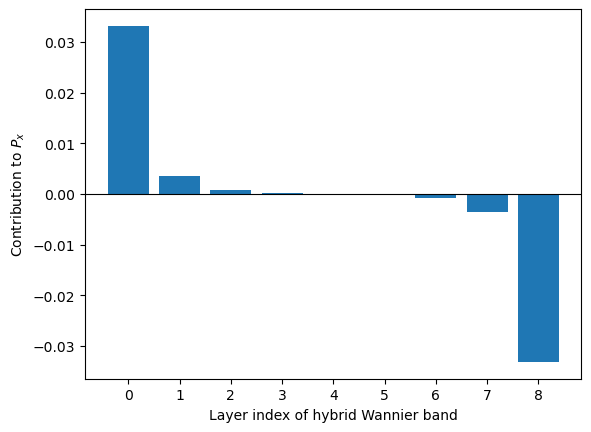

In [12]:
fig = plt.figure()
plt.bar(range(num_layers), px_mean)
plt.axhline(0.0, linewidth=0.8, color="k")
plt.xticks(range(num_layers))
plt.xlabel("Layer index of hybrid Wannier band")
plt.ylabel(r"Contribution to $P_x$")